# Stellar Classification using Photometric data

# Summary

# Introduction

In astronomy, it is useful to classify stars based on certain characteristics. In the earliest days it was based on mass and temperature; however, our modern classification system has evolved and we classify stars based on the *Morgan–Keenan (MK)* system which group stars into 7 classes based on their spectral characteristics. Under the MK system, astronomers analyse electromagnetic radiation from stars to determine its class. These electromagnetic spectrum have dark lines to determine which and how abundant elements are present in the star. The 7 classes in the MK system - *O, B, A, F, G, K*, and *M* - are sequenced from the hottest (*O* type) to the coolest (*K* type) which also exhibits a certain characteristic that is very visible - colour. Hence in this report, we will classify stars using photometric data and in the Discussion section, we will evaluate whether this is a reliable alternative for the traditional method.

## Definitions

**Photometry**: the measurement of the flux or intensity of an astronomical object's electromagnetic radiation

The photometric system we're using to classify star types is the *Sloan* system (add reference) used by the Sloan Digital Sky Survey. The system measures the intensity of electromagnetic radition from stars at 5 bands:
- *u* (345nm)
- *g* (475nm which is a light blue in the visible spectrum)
- *r* (622nm which is orange)
- *i* (763nm which is deep red)
- *z* (905nm)

NASA Exoplanet Archive collects data from various sources, including ground-based observatories and space telescopes such as the Kepler Space Telescope and the Transiting Exoplanet Survey Satellite (TESS). The dataset is we're using is their [Planetary Systems dataset](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS) which has the columns of names, spectral type and measurements using Sloan photometric system selected.

# Methods & Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

exoplanet_data = pd.read_csv('data/2024-03-01-exoplanet_dataset.csv', 
                             header = 13,
                             dtype = {'pl_name' : 'string', 'st_spectype' : 'string'})
print(exoplanet_data)

         pl_name st_spectype  sy_umag  sy_gmag  sy_rmag  sy_imag  sy_zmag
0       11 Com b        <NA>      NaN      NaN      NaN      NaN      NaN
1       11 Com b      G8 III      NaN      NaN      NaN      NaN      NaN
2       11 Com b      G8 III      NaN      NaN      NaN      NaN      NaN
3       11 UMi b        <NA>      NaN      NaN      NaN      NaN      NaN
4       11 UMi b        <NA>      NaN      NaN      NaN      NaN      NaN
...          ...         ...      ...      ...      ...      ...      ...
35843  ups And d        <NA>      NaN      NaN      NaN      NaN      NaN
35844  ups Leo b      G9 III      NaN      NaN      NaN      NaN      NaN
35845   xi Aql b        <NA>      NaN      NaN      NaN      NaN      NaN
35846   xi Aql b        <NA>      NaN      NaN      NaN      NaN      NaN
35847   xi Aql b      K0 III      NaN      NaN      NaN      NaN      NaN

[35848 rows x 7 columns]


This dataset from NASA's Exoplanet Archive include all planets and stars. Therefore we will wrangle the dataset such that it only contain stars with Sloan magnitudes for photometric measurements.

In [2]:
stars_data = exoplanet_data.dropna(subset = ['st_spectype',
                                                  'sy_umag',
                                                  'sy_gmag',
                                                  'sy_rmag',
                                                  'sy_imag',
                                                  'sy_zmag'])
stars_data["st_spectype"] = stars_data['st_spectype'].transform(lambda x: x[0].upper())
only_stars_data = stars_data.loc[stars_data['st_spectype'].isin(['O','B', 'A', 'F', 'G', 'K', 'M'])]
only_stars_data["st_spectype"] = only_stars_data["st_spectype"].astype("category")

with pd.option_context('display.max_rows', 6,
                       'display.max_columns', None,
                       'display.width', 1000,
                       'display.precision', 3,
                       'display.colheader_justify', 'center'):
    display(only_stars_data)

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_53776\818944062.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars_data["st_spectype"] = stars_data['st_spectype'].transform(lambda x: x[0].upper())
C:\Users\VietNgo\AppData\Local\Temp\ipykernel_53776\818944062.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_stars_data["st_spectype"] = only_stars_data["st_spectype"].astype("category")


,pl_name,st_spectype,sy_umag,sy_gmag,sy_rmag,sy_imag,sy_zmag
180,BD+20 2457 b,K,14.913,10.515,9.277,8.840,8.978
182,BD+20 2457 c,K,14.913,10.515,9.277,8.840,8.978
183,BD+20 274 b,K,14.337,10.186,8.942,8.492,8.904
...,...,...,...,...,...,...,...
35702,XO-5 b,G,15.353,15.008,11.989,11.821,13.656
35703,XO-5 b,G,15.353,15.008,11.989,11.821,13.656
35704,XO-5 b,G,15.353,15.008,11.989,11.821,13.656


## Exploratory Data Analysis

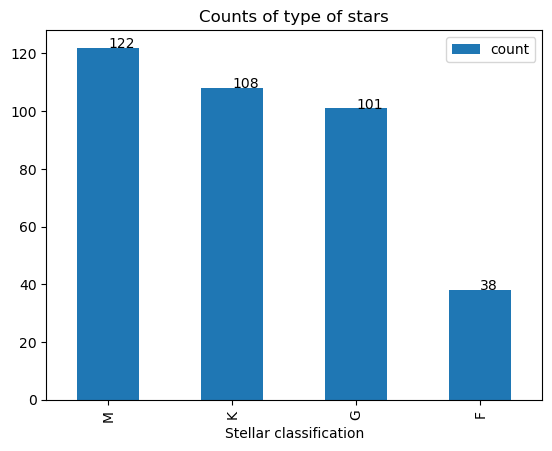

In [3]:
types_summ = pd.DataFrame(only_stars_data["st_spectype"].value_counts())

fig, ax = plt.subplots(1, 1)
types_summ.plot.bar(xlabel = 'Stellar classification', title="Counts of type of stars", ax=ax)

for col in types_summ.columns:
    for id, val in enumerate(types_summ[col]):
        ax.text(id, val, str(val))

There are only 4 classes of stars, *M*, *K*, *G*, *F*, with Sloan magnitudes in our datasets so our classification model can only classify stars into these 4 classes. Most of the stars fall within *M*, *K* and *G* classes